# チームB
## テーマ: ショアのアルゴリズム
## 目標: ショアのアルゴリズムをpython使って実装しよう

# アウトライン
- ショアのアルゴリズム説明
- アダマールテスト
- 位相推定
- ショアのアルゴリズム

## ショアのアルゴリズムとは
量子コンピュータを使って高速で因数分解できるアルゴリズムのこと。  

## 具体的には?

- 因数分解したい数を$N$とする。  
- まず$N$と互いに素で$N$より小さい整数$x$を適当に決める。  
- $x^{r}=1 (mod N)$を満たす位数$r$を求める。  
ただしこの$r$は偶数でなければならない  
- $x^{r}-1=0 \ (mod\  N)$つまり$(x^{r/2}-1)(x^{r/2}+1)=0 \ (mod\ N)$となるから$x^{r/2}-1$か$x^{r/2}+1$のどっちかが$N$と因数をもってる。 

『$x^{r}=1 (mod N)$を満たす位数$r$を求める』

これが古典コンピュータでは$N$に対し指数的な時間がかかる。

しかし量子コンピュータを使えば多項式時間で解けるため、圧倒的に速くなる。

# 今回の目標 --- ショアのアルゴリズムの実装
pythonのnumpyを使って行列的に量子回路を扱う。  
例えばnビットの量子状態を扱うなら、量子状態を表す$2^{n}$行1列の行列に、$2^{n}$行$2^{n}$列の演算を表す行列を左から作用させていく。  
終状態の測定は各成分の絶対値の二乗でその状態が得られるという形で表現できる。

### ショアのアルゴリズムを実装するには

位数推定アルゴリズムが必要。『$x^{r}=1 (mod N)$を満たす位数$r$を求める』

位相推定アルゴリズムが必要。『ユニタリ行列$U$の固有値$e^{i2\pi\phi}$の位相$\phi$を求める』

量子フーリエ変換とかアダマールテストの知識が必要。

今回はまずアダマールテストの説明をして、位相推定、位数推定は軽く紹介。そしてショアのアルゴリズムの実装を示して終わりにする。

# アダマールテストとは
あるユニタリ行列$U$に対して、その固有値$e^{i\lambda}$と固有ベクトル$|\psi>$を一組推定する。  

固有値、固有ベクトルとは行列$U$に対して、次の式を満たす$e^{i\lambda}$と$|\psi>$のことである。  
                        $U|\psi>$=$e^{i\lambda}|\psi>$    
                        
(具体例)
 
$U=\begin{pmatrix}
1 & 0 \\
0 & 1 \\
\end{pmatrix}$
に対して、
$\psi=\begin{pmatrix}
1 \\
0 \\
\end{pmatrix}$
, $e^{i\lambda}=1$とする。  
  
  
このとき
$\begin{pmatrix}
1 & 0 \\
0 & 1 \\
\end{pmatrix}
\begin{pmatrix}
1 \\
0 \\
\end{pmatrix}=
1
\begin{pmatrix}
1 \\
0 \\
\end{pmatrix}$

量子回路にするとこんなの
<img src="picture/admaleTest.png">

第1ビットで0を観測する確率を$P_{0}$とする。  
このとき固有値$e^{i\lambda}$に対する$\lambda$について以下の式が成り立つ。  
$cos\lambda=2P_{0}-1$  
この式から固有値が求められる。

### 早速アダマールテストの実装の様子を見てみよう

行列演算の処理にはnumpyを用いる。

In [1]:
import numpy as np
import math

### 制御Uゲートの作成
任意のユニタリ行列UについてCU_gateを作成する。第一ビットが0の時は他ビットは変化しない(単位行列Iが作用する)。第一ビットが1の時は他ビットにUを作用させる。量子ビットに作用させられるUは$2^{n}*2^{n}$行列のみ。

In [2]:
def get_CU_gate(U):
    m,m=U.shape
    n=int(math.log(m,2))
    
    I=np.array([[1,0],[0,1]])
    CU_zero=np.array([[1,0],[0,0]]) # |0><0| 1ビット目は|0>なら|0>を|1>なら|1>を返す
    CU_one=np.array([[0,0],[0,1]]) # |1><1|
    
    for i in range(n):
            CU_zero=np.kron(CU_zero,I) # 1ビット目が|0>ならそれ以降のnビットにはIを作用させる
    
    CU_one=np.kron(CU_one,U) # 1ビット目が|1>ならそれ以降のnビットにはUを作用させる
    
    return CU_zero+CU_one

In [3]:
X=np.array([[0,1],
            [1,0]])
get_CU_gate(X)

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0]])

### アダマールゲートの作成
第一ビットにのみアダマールゲートHを作用させ、その他のビットには変化を加えない(単位行列Iを作用させる)ような行列を作成する。

In [4]:
def get_H_gate(U):
    m,m=U.shape
    n=int(math.log(m,2))
    
    H=np.array([[1,1],[1,-1]])/math.sqrt(2)
    I=np.array([[1,0],[0,1]])
    
    H_gate=H
    
    for i in range(n):
        H_gate=np.kron(H_gate,I)
    
    return H_gate

In [5]:
X=np.array([[0,1],[1,0]])
get_H_gate(X)

array([[ 0.70710678,  0.        ,  0.70710678,  0.        ],
       [ 0.        ,  0.70710678,  0.        ,  0.70710678],
       [ 0.70710678,  0.        , -0.70710678, -0.        ],
       [ 0.        ,  0.70710678, -0.        , -0.70710678]])

### $2^{n}*2^{n}$のユニタリ行列Uと$2^{n}$行$1$列(nビット)の$\phi$を引数としてアダマールテストを行う  
初期状態に、しかるべき演算子を行列の形で左からかけていく。

In [6]:
def hadamard_test(U,phi):
    
    # 初期状態を定める
    zero_bit=np.array([[1],[0]])
    state=np.kron(zero_bit,phi) # 第1ビットは|0>に固定でよい
    
    # stateにH_gateを作用させる
    state=np.dot(get_H_gate(U),state)
    
    # stateにCU_gateを作用させる
    state=np.dot(get_CU_gate(U),state)
    
    # stateにH_gateを作用させる
    state=np.dot(get_H_gate(U),state)
    
    return state # 返すのは終状態

### アダマールテストの結果を用いて固有値を求める。  
まず終状態の1ビット目で0が測定される確率を求める。  
次にそれを用いて固有値$e^{i\lambda}$に対する$\cos{\lambda}$を求める。  
後はそれを$e^{i\lambda}=\cos{\lambda}+i\sin{\lambda}$に代入してやればいい。

In [7]:
def get_IV_1(state):
    m,k=state.shape
    n=int(math.log(m,2))
    
    PZero=sum([abs(state[i,0])**2 for i in range(2**(n-1))])
    
    cosL=2*PZero-1
    
    # 虚部が正の方を返す
    return cosL+math.sqrt(1-cosL**2)*1j

In [8]:
def get_IV_2(state):
    m,k=state.shape
    n=int(math.log(m,2))
    
    PZero=sum([abs(state[i,0])**2 for i in range(2**(n-1))])
    
    cosL=2*PZero-1
    
    # 虚部が負の方を返す
    return cosL-math.sqrt(1-cosL**2)*1j

実際に行列Xとその固有ベクトルを引数として固有値を求めてみる。

In [9]:
X=np.array([[0,1],[1,0]])

phi1=np.array([[1],[1]])/math.sqrt(2) # Xの固有ベクトルその1
phi2=np.array([[1],[-1]])/math.sqrt(2) # Xの固有ベクトルその2

state1=hadamard_test(X,phi1)
state2=hadamard_test(X,phi2)

print(get_IV_1(state1),get_IV_2(state1))
print(get_IV_1(state2),get_IV_2(state2))

(0.9999999999999991+4.2146848510894035e-08j) (0.9999999999999991-4.2146848510894035e-08j)
(-1+0j) (-1+0j)


Xの固有値と固有ベクトルを既存のメソッドで計算してみると以下のようになる。

In [10]:
def get_answer(U):
    w,v=np.linalg.eig(U)
    
    for i in range(len(w)):
        print('value:',w[i],' vector:',v[:,i])

In [11]:
X=np.array([[0,1],[1,0]])
get_answer(X)

value: 1.0  vector: [0.70710678 0.70710678]
value: -1.0  vector: [-0.70710678  0.70710678]


これよりアダマールテストで求めた固有値はほぼ正しいことが分かる。

### 次に初期状態を０ビットに固定してアダマールテストを行う

In [12]:
X=np.array([[0,1],[1,0]])
get_answer(X) # 先に固有値と固有ベクトルを出しておく

value: 1.0  vector: [0.70710678 0.70710678]
value: -1.0  vector: [-0.70710678  0.70710678]


In [13]:
state=hadamard_test(X,[[1],[0]])
get_IV_1(state),get_IV_2(state)

((-4.440892098500626e-16+1j), (-4.440892098500626e-16-1j))

どっちの固有値とも一致しない   
別のユニタリ行列でも試してみる

In [14]:
Z=np.array([[1,0],[0,-1]])
get_answer(Z) # 先に固有値と固有ベクトルを出しておく

value: 1.0  vector: [1. 0.]
value: -1.0  vector: [0. 1.]


In [15]:
state=hadamard_test(Z,[[1],[0]])
get_IV_1(state),get_IV_2(state)

((0.9999999999999991+4.2146848510894035e-08j),
 (0.9999999999999991-4.2146848510894035e-08j))

これは一致してる。

### アダマールテストループ
こんな感じで固有値が求まるかはまちまち。これを解決するためにアダマールテストを何回も繰り返す。これにより終状態が固有ベクトルに収束していく。  
何回も繰り返すとは、一度アダマールテストした後の第1ビット以外のビットの情報を取り出し、それを初期状態に使ってもう一度アダマールテストを行う。

In [16]:
def hadamard_loop(U,loop):
    m,m=U.shape
    n=int(math.log(m,2))
    zero=[[1],[0]]
    state=zero
    
    for i in range(n-1):
        state=np.kron(state,zero) # 初期状態を|00...0>にする
    
    for i in range(loop):
        end_state=hadamard_test(U,state)
        # アダマールテストで帰ってきたend_stateから１ビット目の情報を抜き取っていく
        end_state0, end_state1=np.split(end_state,[2**n],axis=0) # end_stateを上下に分ける
        PZero=sum([abs(end_state[i,0])**2 for i in range(2**(n-1))]) # １ビット目で0が観測される確率
        if PZero==0:
            state=end_state1
        else:
            state=end_state0/((PZero)**(1/2)) # 1ビット目の情報を取り除こうとしている。
            
    cosL=2*PZero-1
    cosL=min(cosL,1)
    return cosL+math.sqrt(1-cosL**2)*1j,cosL-math.sqrt(1-cosL**2)*1j # 返すのは固有値(ただし虚部の符号は分からないので両方返す)

In [17]:
X=np.array([[0,1],[1,0]])
get_answer(X) # 先に固有値と固有ベクトルを出しておく

value: 1.0  vector: [0.70710678 0.70710678]
value: -1.0  vector: [-0.70710678  0.70710678]


In [18]:
hadamard_loop(X,1) #ループ一回

((-0.5000000000000002+0.8660254037844385j),
 (-0.5000000000000002-0.8660254037844385j))

In [19]:
hadamard_loop(X,2) #ループ二回

((0.9999999999999991+4.2146848510894035e-08j),
 (0.9999999999999991-4.2146848510894035e-08j))

In [20]:
hadamard_loop(X,3) #ループ三回

((0.9999999999999991+4.2146848510894035e-08j),
 (0.9999999999999991-4.2146848510894035e-08j))

ユニタリ行列Xでは、ループ二回目でほぼ正しい固有値が得られる

ちょっとこの固有値の収束の様子を可視化してみよう  
可視化にはmatplotlibを用いた。

In [21]:
import matplotlib.pyplot as plt
import numpy as np

In [22]:
def hadamard_vd(U,loop):
    data_R=[]
    data_I=[]
    num=np.arange(loop)

    for i in range(loop):
        IV_tuple=hadamard_loop(U,i+1) # 1回行ったアダマールテストを利用して２回目のアダマールテストを行うようにすれば速くなる(してない)
        IV=IV_tuple[0] # tupleでは不便なので取り出しておく
        data_R.append(IV.real) # 固有値を実部と虚部に分ける
        data_I.append(IV.imag)

    plt.plot(num, data_R, label="IV_R")
    plt.plot(num, data_I, label="IV_I")
    plt.grid()
    plt.legend()
    plt.xlabel("num")
    plt.ylabel("IV")
    plt.show()

In [23]:
# 実験に使う基本的なゲートを定義しておく
PI=math.pi
e=math.e

X=np.array([[0,1],[1,0]])
Y=np.array([[0,-1j],[1j,0]])
Z=np.array([[1,0],[0,-1]])
H=np.array([[1,1],[1,-1]])/math.sqrt(2)
T=np.array([[e**(1j*(PI/8)),0],[0,e**(1j*(PI/8))]])
CNOT=get_CU_gate(X)

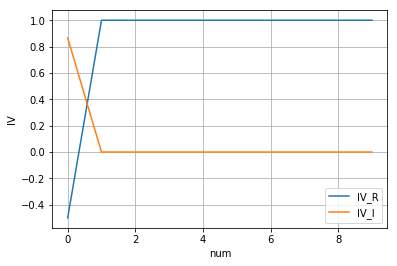

value: 1.0  vector: [0.70710678 0.70710678]
value: -1.0  vector: [-0.70710678  0.70710678]


In [24]:
hadamard_vd(X,10)
get_answer(X)

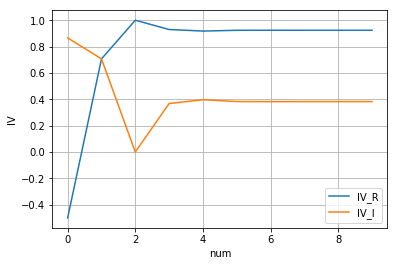

value: (0.9238795325112865+0.3826834323650897j)  vector: [ 7.07106781e-01+0.j         -0.00000000e+00+0.j
 -0.00000000e+00+0.j         -0.00000000e+00+0.j
 -0.00000000e+00+0.j         -0.00000000e+00+0.j
  2.77555756e-17+0.70710678j -0.00000000e+00+0.j        ]
value: (-0.9238795325112867-0.38268343236508984j)  vector: [7.07106781e-01+0.j         0.00000000e+00+0.j
 0.00000000e+00+0.j         0.00000000e+00+0.j
 0.00000000e+00+0.j         0.00000000e+00+0.j
 5.55111512e-17-0.70710678j 0.00000000e+00+0.j        ]
value: (0.9238795325112865+0.3826834323650897j)  vector: [-0.00000000e+00+0.j         -0.00000000e+00+0.j
  7.07106781e-01+0.j         -0.00000000e+00+0.j
 -2.77555756e-17-0.70710678j -0.00000000e+00+0.j
 -0.00000000e+00+0.j         -0.00000000e+00+0.j        ]
value: (-0.9238795325112867-0.38268343236508984j)  vector: [ 0.00000000e+00+0.j          0.00000000e+00+0.j
  7.07106781e-01+0.j          0.00000000e+00+0.j
 -5.55111512e-17+0.70710678j  0.00000000e+00+0.j
  0.00000000e+

In [25]:
MyGate=np.kron(X,np.kron(Y,T))
hadamard_vd(MyGate, 10)
get_answer(MyGate)

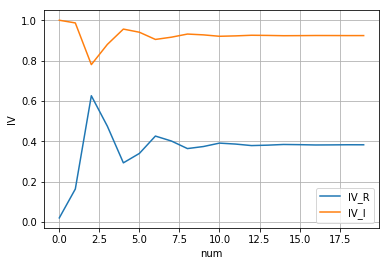

value: (0.38268343236508984-0.9238795325112867j)  vector: [0.92387953+0.00000000e+00j 0.38268343+2.77555756e-17j]
value: (-0.3826834323650896+0.9238795325112866j)  vector: [-0.38268343+0.j  0.92387953+0.j]


In [26]:
MyGate2=T@H@Z@Y@X
hadamard_vd(MyGate2,20)
get_answer(MyGate2)

いずれもうまく固有値に収束している。  
アダマールテストはうまくいったので次は位相推定。

# 位相推定アルゴリズム
位相とはさっきの固有値$e^{i2\pi\phi}$の$\phi$のこと。ユニタリ行列$U$と固有状態$|\psi>$を受け取り$\phi$を返す関数を組む。

量子回路にするとこんなの
<img src="picture/isouSuitei.png">

#### 量子回路に描いてあることを文章化
1. ユニタリ行列Uの固有値を$e^{i2\pi\phi}$としたとき、求めたい位相は$\phi$である($0\leqq\phi<1$)。ここで$\phi$を二進数で表すと、$0.\phi_{1}\phi_{2}...\phi_{r}$ であるとする。
2. 0からr-1番目のビットに対してアダマールゲートを作用させる。
3. kビット目を制御ビットとし、固有状態$\psi$をターゲットビットとした$CU_{k}$ゲートを行列表現し左から作用させる($0 \leqq k \leqq r-1$) ($r$は精度を表す)($U_{k}=U^{2^{k}}$)。
4. 0からr-1番目のビットを対象に逆量子フーリエ変換を行う。
5. 0からr-1番目のビット列は$|\phi_{1}\phi_{2}...\phi_{r}>$になっているためこれを行列表現された状態から得る。$\phi_{1}\phi_{2}...\phi_{r}$を$2^{r}$で割って、位相$\phi$を得る。

In [27]:
def get_vec_list(U):
    w,v=np.linalg.eig(U)
    vec_list=[]
    
    for i in range(len(w)):
        x=v[:,i]
        vec_list.append(x.reshape(len(x),1))
    
    return vec_list

In [28]:
def get_state(psi,r):
    zero=np.zeros((2**r,1))
    zero[0]=1
    return np.kron(zero,psi)

In [29]:
def get_H_gate(U,r):
    m,m=U.shape
    n=int(math.log(m,2))
    H_gate=np.array([[1]])
    H=np.array([[1,1],[1,-1]])/math.sqrt(2)
    for i in range(r):
        H_gate=np.kron(H_gate,H)
    return np.kron(H_gate,np.eye((2**n)))

In [30]:
def get_CUk_list(U,r):
    m,m=U.shape
    n=int(math.log(m,2))
    zero=np.array([[1,0],[0,0]])
    one=np.array([[0,0],[0,1]])
    
    # まずはUk_listを作る
    Uk_list=[U]
    for i in range(r-1):
        Uk_list.append(Uk_list[i]@Uk_list[i])
    
    # 次にCUk_listを作る CUkの制御ビットはr-1-k番目のビット、標的ビットは2**n行の固有状態
    CUk_list=[]
    for k in range(r):
        CUk_zero=np.kron(np.eye((2**(r-1-k))),np.kron(zero,np.kron(np.eye((2**(k))),np.eye((2**n)))))
        CUk_one=np.kron(np.eye((2**(r-1-k))),np.kron(one,np.kron(np.eye((2**(k))),Uk_list[k])))
        CUk_list.append(CUk_zero+CUk_one)
    
    return CUk_list    

In [31]:
def get_Rm(n,t,m):
    zero=np.array([[1,0],[0,0]])
    one=np.array([[0,0],[0,1]])
    
    Rm_zero=np.kron(np.eye((2**(t+m-1))),np.kron(zero,np.eye(2**(n-t-m))))
    Rm_one=np.kron(np.eye(2**t),np.kron(zero+(math.e**(2j*math.pi/2**m))*one,np.kron(np.eye((2**(m-2))),np.kron(one,np.eye((2**(n-t-m)))))))
    
    return Rm_zero+Rm_one

In [32]:
def get_HR(n,t):
    H=np.array([[1,1],[1,-1]])/math.sqrt(2)
    HR=np.kron(np.eye((2**t)),np.kron(H,np.eye(2**(n-t-1))))
    
    if t==n-1:
        return HR
    for i in range(2, n-t+1, 1):
        HR=get_Rm(n,t,i)@HR # 左にどんどんかけていく
    
    return HR

In [33]:
def change(n,a,b):
    zero=np.array([[1,0],[0,0]])
    one=np.array([[0,0],[0,1]])
    X=np.array([[0,1],[1,0]])
    
    CNOT_a=np.kron(np.eye((2**a)),np.kron(zero,np.eye((2**(n-a-1)))))+np.kron(np.eye((2**a)),np.kron(one,np.kron(np.eye((2**(b-a-1))),np.kron(X,np.eye((2**(n-b-1)))))))
    CNOT_b=np.kron(np.eye((2**b)),np.kron(zero,np.eye((2**(n-b-1)))))+np.kron(np.eye((2**a)),np.kron(X,np.kron(np.eye((2**(b-a-1))),np.kron(one,np.eye((2**(n-b-1)))))))
    return CNOT_a@CNOT_b@CNOT_a

In [34]:
def get_swap(n):
    swap=np.eye((2**n))
    if n%2==0:
        for i in range(int(n/2)):
            swap=change(n,i,n-1-i)@swap
    else:
        for i in range(int((n-1)/2)):
            swap=change(n,i,n-1-i)@swap
    return swap

In [35]:
def Q_Fourier(n):
    Q_Fourier=np.eye((2**n))
    for i in range(n):
        Q_Fourier=get_HR(n,i)@Q_Fourier
    return get_swap(n)@Q_Fourier

In [36]:
def inv_Fourier(n):
    IF=np.conjugate(Q_Fourier(n))
    return IF.T

In [37]:
def get_inv_Fourier(U,r):
    m,m=U.shape
    n=int(math.log(m,2))
    return np.kron(inv_Fourier(r),np.eye((2**n)))

In [38]:
def get_phase(state,r):
    psi=0
    
    for i in range(r):
        n,m=state.shape
        S=sum([abs(state[j])**2 for j in range(int(n/2))]) # stateの上半分の絶対値の二乗の和
        state_a, state_b=np.split(state,[int(n/2)],axis=0) # stateを上下に分割
        
        if 0.99<S<=1:
            state=state_a
        
        elif 0<=S<0.01:
            state=state_b
            psi+=(1/2)**(i+1) # 二進数を十進数にする
        
        else:
            return psi,"Error ビットが確定していません"
    
    return psi

さっき文章化したものを一つ一つ行列で表現していき、まとめたものがこちら  
ユニタリ行列U、その固有状態psi、そして精度を示すrを受け取り位相$\psi$を返す関数

In [39]:
def phase_estimate_1(U,psi,r):
    # 初期状態の生成
    state=get_state(psi,r)
    
    # 0からr-1番目のビットにアダマールゲートを作用させる
    state=get_H_gate(U,r)@ state
    
    # k番目のビットを制御ビットとし、psiを標的ビットとしたCUkゲートを作用させる。(k=0～r-1)
    CUk_list=get_CUk_list(U,r)
    for i in range(r):
        state=CUk_list[i]@ state
    
    # 最後に0からr-1番目のビットに逆量子フーリエ変換を作用させる。
    state=get_inv_Fourier(U,r)@ state
    
    # 0からr-1番目のビット列は$|\phi_{1}\phi_{2}...\phi_{r}>$になっているためこれを行列表現された状態から得る。
    return get_phase(state,r)

In [40]:
def all_phase(U,r):
    vec_list=get_vec_list(U)
    for vec in vec_list:
        print("固有状態: "+str(vec)+"  位相: "+str(phase_estimate_1(U,vec,r)))

In [41]:
def get_answer(U):
    """"答え合わせ用の関数"""
    w,v=np.linalg.eig(U)
    
    for i in range(len(w)):
        print('value:',w[i],' vector:',v[:,i])

In [42]:
MyGate=np.array([[1j,0],[0,1j]]) # なにか位相が分かっているもので確かめる
get_answer(MyGate)
all_phase(MyGate,3) # すべての固有値に対して位相推定

value: 1j  vector: [1.+0.j 0.+0.j]
value: 1j  vector: [0.+0.j 1.+0.j]
固有状態: [[1.+0.j]
 [0.+0.j]]  位相: 0.25
固有状態: [[0.+0.j]
 [1.+0.j]]  位相: 0.25


位相1/4なら固有値は1jになるので多分あってる。

In [43]:
I=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
get_answer(I)
all_phase(I,2)

value: 1.0  vector: [1. 0. 0. 0.]
value: 1.0  vector: [0. 1. 0. 0.]
value: 1.0  vector: [0. 0. 1. 0.]
value: 1.0  vector: [0. 0. 0. 1.]
固有状態: [[1.]
 [0.]
 [0.]
 [0.]]  位相: 0
固有状態: [[0.]
 [1.]
 [0.]
 [0.]]  位相: 0
固有状態: [[0.]
 [0.]
 [1.]
 [0.]]  位相: 0
固有状態: [[0.]
 [0.]
 [0.]
 [1.]]  位相: 0


やっぱりあってる  
今までの経験を使いショアのアルゴリズムへ

# ショアのアルゴリズム
位数推定アルゴリズムを利用してショアのアルゴリズムを行列でシュミレートする。

### やりたいことの確認
1. 因数分解したい数Nに対して、Nと互いに素でありNより小さい自然数xを定める。  
2. そのNとxを使って、ユニタリ行列$U_{x}=\sum_{y=0}^{2^{n}-1} |xy (mod N)><y|$ を行列表現する。($2^{n-1}-1<N-1<=2^{n}-1$)  
3. その$U_{x}$の固有値の位相$\phi$を推定する。  
4. $s/t(=\phi)$に対して連分数展開を行い位数$t$を求める。
5. $t$が偶数なら$gcd(x^{t/2}-1,N)$か$gcd(x^{t/2}+1,N)$がNの因数となる。

全部紹介するのもお互い疲れるので、一番大事な位相推定のところを紹介。

さっきの位相推定とはちがって、初期状態に固有ベクトルを使わない。

かわりにすべての固有状態が重ね合わさった$|00...001>$を固有状態の代わりに使う。

そうすることでそれぞれの固有状態に対する固有値の位相が確率的に観測できる。

In [44]:
import numpy as np
import math
import random # 疑似量子的観測に用いる
from fractions import Fraction # 有理数近似に用いる
import re # 分母を取り出すときに用いる

In [45]:
def find_x(N):
    for x in range(2,int(N)):
        if math.gcd(x,int(N))==1:
            yield x
        else:
            continue

In [46]:
def get_Ux(N,x):
    # Nに対するnを求める
    i=0
    while(True):
        if N<=2**i:
            n=i
            break
        else:
            i+=1
    
    Ux=np.zeros((2**n,2**n))
    
    for y in range(2**n):
        ket=np.zeros((2**n,1))
        ket[(x*y)%N,0]=1
        bra=np.zeros((1,2**n))
        bra[0,y]=1
        Ux=Ux+np.kron(ket,bra)
    
    return Ux

In [47]:
def get_phase(state,r):
    # 0ビット目からr-1ビット目までを確率的に観測する関数
    psi=0
    
    for k in range(r):
        n,m=state.shape
        Pzero=sum([abs(state[j])**2 for j in range(int(n/2))]) # stateの上半分の絶対値の二乗の和
        state_a, state_b=np.split(state,[int(n/2)],axis=0) # stateを上下に分割
        P=random.random() # 疑似的に量子的な観測を行うためサイコロを振る
        
        if P<=Pzero:
            state=state_a/(Pzero**(1/2)) # kビット目が|0>なら何もしないで、上半分を次に使う
        
        elif Pzero<P:
            state=state_b/((1-Pzero)**(1/2)) # kビット目が|1>なら下半分を次に使う
            psi+=(1/2)**(k+1) # 二進数を十進数にする
        
        else:
            return psi,"Error"
    
    return psi

In [48]:
def phase_estimate(U):
    # 初期状態の生成
    m,m=U.shape
    n=int(math.log(m,2))
    r=n
    
    psi=np.zeros((2**n,1))
    psi[1]=1 # 初期状態の作成に使う psi は|00...01>を使う。上から二番目の要素だけ1にすればOK
    state=get_state(psi,r)
    
    # 0からr-1番目のビットにアダマールゲートを作用させる
    state=get_H_gate(U,r)@ state
    
    # k番目のビットを制御ビットとし、psiを標的ビットとしたCUkゲートを作用させる。(k=0～r-1)
    CUk_list=get_CUk_list(U,r)
    for i in range(r):
        state=CUk_list[i]@ state
    
    # 最後に0からr-1番目のビットに逆量子フーリエ変換を作用させる。
    state=get_inv_Fourier(U,r)@ state

    # 0からr-1番目のビット列は$|\phi_{1}\phi_{2}...\phi_{r}>$になっているためこれを行列表現された状態から得る。
    return Fraction(get_phase(state,r))

位相の推定を見てみる

In [61]:
# 位相推定と違って出てくる位相は一つに確定していない
# 実機と同じ挙動でs/tが得られる。あとはFractionで有理数近似するだけ。
N,x=15,7
Ux=get_Ux(N,x)
for i in range(10):
    st=phase_estimate(Ux)
    print("位相: "+str(st))

位相: 1/4
位相: 1/4
位相: 1/2
位相: 0
位相: 1/4
位相: 3/4
位相: 1/4
位相: 0
位相: 1/2
位相: 0


この場合位数としては2,4が候補である      
$7^{2}=4(mod15)$  
$7^{4}=1(mod15)$  
位数として条件を満たすのは4である  
このように確率的に位相が求まる...訳では無くxの取り方によっては求められない。  
例: (N,x)=(21,5)  
この場合はxを取り直せば良い。

In [50]:
def get_den(frac):
    str_frac=str(Fraction(frac))
    pattern = "(.*)/(.*)"
    d = re.split(pattern, str_frac)
    return int(d[2])

In [51]:
def get_dig(N,x):
    Ux=get_Ux(N,x)
    st=phase_estimate(Ux)
    if st==0:
        return st
    else:
        t=get_den(st)
        return t

次は位数推定。

In [52]:
for i in range(10):
    print("位数: "+str(get_dig(15,7)))

位数: 0
位数: 0
位数: 4
位数: 0
位数: 4
位数: 0
位数: 0
位数: 2
位数: 2
位数: 2


位数$t$が求まったら、$gcd(x^{t/2}-1,N)$か$gcd(x^{t/2}+1,N)$がNの因数となる。  
ちなみに$t$は必ず2の乗数である。  
注意事項としては、後々の都合により$t=0$の場合は因数として$1$を返すことにしている。  
同様に因数が見つからなかった場合も$1$を返すことにした。

In [53]:
def get_fac(N,x):
    t=get_dig(N,x) # 位数を確率的に取得
    
    if t==0:
        return 1
    else:
        fac1=math.gcd(x**int((t/2))-1,N)
        fac2=math.gcd(x**int((t/2))+1,N)
        if N%fac1==0:
            return fac1
        elif N%fac2==0:
            return fac2
        else:
            return 1

In [54]:
for i in range(10):
    print("因数: "+str(get_fac(15,7)))

因数: 1
因数: 1
因数: 3
因数: 1
因数: 3
因数: 1
因数: 1
因数: 3
因数: 3
因数: 3


後は自然数Nを受け取り因数分解する関数を作れば良い。  
ただ一応素数判定は使わしてもらうことにする(本当は無しで組みたい)。  
Nが素数ならFalse,違うならTrueを返す。

In [55]:
def judge(N):
    p = N ** 0.5
    p = int(p) + 1
    for i in range(2, int(p)):
        if N % i == 0:
            return True
            break
    else:
        return False

In [56]:
def Q_shor(N):
    fac_list=[]
    while(judge(N)):
        for x in find_x(N): # xはランダムというよりは前から順番に選んでいくことにする。
            fac=get_fac(N,x) # 因数の候補を取得
            if N%fac==0 and fac!=1:
                fac_list.append(fac)
                N=int(N/fac)
                break
    fac_list.append(N)
    return fac_list

In [62]:
Q_shor(5*7)

[5, 7]

ショアのアルゴリズムの実装ができた!　(くそ遅いけど)

# まとめ

# 成果
- ショアのアルゴリズムの実装に成功
- その他、アダマールテスト、位相推定、量子フーリエ変換などを扱えた

# 課題
- アダマールテストをループさせるだけでも位相推定はできるわけでそれを使った因数分解もできるはず
- ショアのアルゴリズムの実行速度をあげてみたりできそう
- 実行時間のブレ幅とかを測定しても面白そう

以上でチームBの発表を終わりたいと思います

# ご清聴ありがとうございました